# Proposal Document

## Introduction

### Background

#### General Description

#### Integrated Profile

#### DM-SNR Curve

In [32]:
#Read packages into R
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(reshape)
options(repr.matrix.max.rows = 6)


Attaching package: ‘reshape’


The following object is masked from ‘package:dplyr’:

    rename


The following objects are masked from ‘package:tidyr’:

    expand, smiths




In [25]:
pulsar_base_data = read_csv("pulsar_data_train.csv", skip = 1,
                            col_names = c("mean_prof", "sd_prof", 
                                          "kurt_prof", "skew_prof", "mean_DMSNR",
                                          "sd_DMSNR","kurt_DMSNR","skew_DMSNR", "target_class")) %>% 
                    mutate(target_class = as_factor(target_class)) %>% 
                    mutate(target_class = fct_recode(target_class,
                                                    "non_pulsar" = '0',
                                                    "pulsar" = '1')) %>% 
                    drop_na()
           
colnames(pulsar_base_data)
head(pulsar_base_data)

Parsed with column specification:
cols(
  mean_prof = col_double(),
  sd_prof = col_double(),
  kurt_prof = col_double(),
  skew_prof = col_double(),
  mean_DMSNR = col_double(),
  sd_DMSNR = col_double(),
  kurt_DMSNR = col_double(),
  skew_DMSNR = col_double(),
  target_class = col_double()
)



[1] "mean_prof"    "sd_prof"      "kurt_prof"    "skew_prof"    "mean_DMSNR"  
[6] "sd_DMSNR"     "kurt_DMSNR"   "skew_DMSNR"   "target_class"

mean_prof,sd_prof,kurt_prof,skew_prof,mean_DMSNR,sd_DMSNR,kurt_DMSNR,skew_DMSNR,target_class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
121.15625,48.37297,0.3754847,-0.01316549,3.168896,18.39937,7.449874,65.15930,non_pulsar
76.96875,36.17556,0.7128979,3.38871856,2.399666,17.57100,9.414652,102.72297,non_pulsar
130.58594,53.22953,0.1334083,-0.29724164,2.743311,22.36255,8.508364,74.03132,non_pulsar
84.80469,36.11766,0.8250128,3.27412537,2.790134,20.61801,8.405008,76.29113,non_pulsar
109.40625,55.91252,0.5651059,0.05624666,2.797659,19.49653,9.443282,97.37458,non_pulsar
95.00781,40.21981,0.3475781,1.15316438,2.770067,18.21774,7.851205,70.80194,non_pulsar


In [26]:
set.seed(632)
pulsar_split = initial_split(pulsar_base_data, prop = 0.8, strata = target_class)
pulsar_train = training(pulsar_split)
pulsar_test = testing(pulsar_split)
head(pulsar_train); head(pulsar_test)

mean_prof,sd_prof,kurt_prof,skew_prof,mean_DMSNR,sd_DMSNR,kurt_DMSNR,skew_DMSNR,target_class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
121.15625,48.37297,0.37548466,-0.01316549,3.168896,18.39937,7.449874,65.15930,non_pulsar
76.96875,36.17556,0.71289786,3.38871856,2.399666,17.57100,9.414652,102.72297,non_pulsar
130.58594,53.22953,0.13340829,-0.29724164,2.743311,22.36255,8.508364,74.03132,non_pulsar
109.40625,55.91252,0.56510595,0.05624666,2.797659,19.49653,9.443282,97.37458,non_pulsar
95.00781,40.21981,0.34757810,1.15316438,2.770067,18.21774,7.851205,70.80194,non_pulsar
130.08594,46.40262,-0.04658483,-0.03446839,5.050167,27.99748,6.059849,38.15479,non_pulsar


mean_prof,sd_prof,kurt_prof,skew_prof,mean_DMSNR,sd_DMSNR,kurt_DMSNR,skew_DMSNR,target_class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
84.80469,36.11766,0.82501279,3.2741254,2.790134,20.61801,8.4050084,76.2911279,non_pulsar
150.09375,56.70048,-0.25668281,-0.5947059,137.148829,51.22346,-0.5409187,0.5988466,non_pulsar
133.12500,59.95728,0.01285505,-0.8048902,31.553512,65.23625,1.7351796,1.3585077,non_pulsar
99.28125,71.95647,0.76555785,-0.8276400,197.234114,63.75880,-1.8763877,2.4312966,non_pulsar
128.48438,50.99142,0.05837666,-0.4959196,1.756689,16.89744,11.7580678,152.8897009,non_pulsar
98.57031,45.06951,0.34915688,0.8533186,1.815217,13.49266,10.8002639,146.3933250,non_pulsar


In [31]:
# Table of some summary statistics fore each variable
summary_train_large = pulsar_train %>% 
    group_by(target_class) %>% 
    summarize_all(list(mean = mean, sd = sd, min = min, max = max)) %>% 
    pivot_longer(cols = mean_prof_mean:skew_DMSNR_max,
                names_to = "summary_data",
                values_to = "values")
summary_train_large

target_class,summary_data,values
<fct>,<chr>,<dbl>
non_pulsar,mean_prof_mean,116.7316095
non_pulsar,sd_prof_mean,47.3379435
non_pulsar,kurt_prof_mean,0.2072302
⋮,⋮,⋮
pulsar,sd_DMSNR_max,109.6553
pulsar,kurt_DMSNR_max,19.6228
pulsar,skew_DMSNR_max,479.6710


In [34]:
#Standardization of all predictor variables
pulsar_recipe_train = recipe(target_class~., data = pulsar_train) %>% 
                    step_scale(all_predictors()) %>% 
                    step_center(all_predictors()) %>% 
                    prep()
scaled_pulsar_train = bake(pulsar_recipe, pulsar_train)
head(scaled_pulsar_train)

pulsar_recipe_test = recipe(target_class~., data = pulsar_test) %>% 
                    step_scale(all_predictors()) %>% 
                    step_center(all_predictors()) %>% 
                    prep()
scaled_pulsar_test = bake(pulsar_recipe, pulsar_test)
head(scaled_pulsar_test)

mean_prof,sd_prof,kurt_prof,skew_prof,mean_DMSNR,sd_DMSNR,kurt_DMSNR,skew_DMSNR,target_class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.39018694,0.27412338,-0.09714898,-0.2869353,-0.3213805,-0.40570241,-0.19298366,-0.37556899,non_pulsar
-1.33008102,-1.52455524,0.21785037,0.2542001,-0.3472224,-0.44809023,0.23884387,-0.02829310,non_pulsar
0.75729504,0.99029113,-0.32314459,-0.3321231,-0.3356778,-0.20290547,0.03965582,-0.29354718,non_pulsar
-0.06725348,1.38593493,0.07987605,-0.2758940,-0.3338520,-0.34956051,0.24513627,-0.07773898,non_pulsar
-0.62780048,-0.92817443,-0.12320175,-0.1014080,-0.3347790,-0.41499622,-0.10477741,-0.32340283,non_pulsar
0.73782949,-0.01643168,-0.49118104,-0.2903240,-0.2581801,0.08543455,-0.49848937,-0.62522549,non_pulsar


mean_prof,sd_prof,kurt_prof,skew_prof,mean_DMSNR,sd_DMSNR,kurt_DMSNR,skew_DMSNR,target_class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
-1.0250194,-1.5330931,0.3225177,0.2359718,-0.3341048,-0.2921741,0.01693992,-0.2726553,non_pulsar
1.5167556,1.5021304,-0.6873225,-0.3794406,4.1796076,1.2739120,-1.94923506,-0.9724299,non_pulsar
0.8561435,1.9823905,-0.4356897,-0.4128744,0.6321863,1.9909493,-1.44898421,-0.9654068,non_pulsar
-0.4614309,3.7518385,0.2670122,-0.4164932,6.1981424,1.9153476,-2.24275027,-0.9554889,non_pulsar
0.6754789,0.6602499,-0.3931920,-0.3637267,-0.3688229,-0.4825561,0.75388999,0.4354979,non_pulsar
-0.4891084,-0.2130180,-0.1217278,-0.1491043,-0.3668566,-0.6567793,0.54337966,0.3754389,non_pulsar


## To-do

Visualize all variables:
- boxplots
- heatmap ggpairs()
- scatterplot with colours points (a few different pairs)
- group_by target class, produce summary statistics

4 KNN pairs by summary stat (mean, sd, kurt, skew)
2 KNN by prof vs DMSNR

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



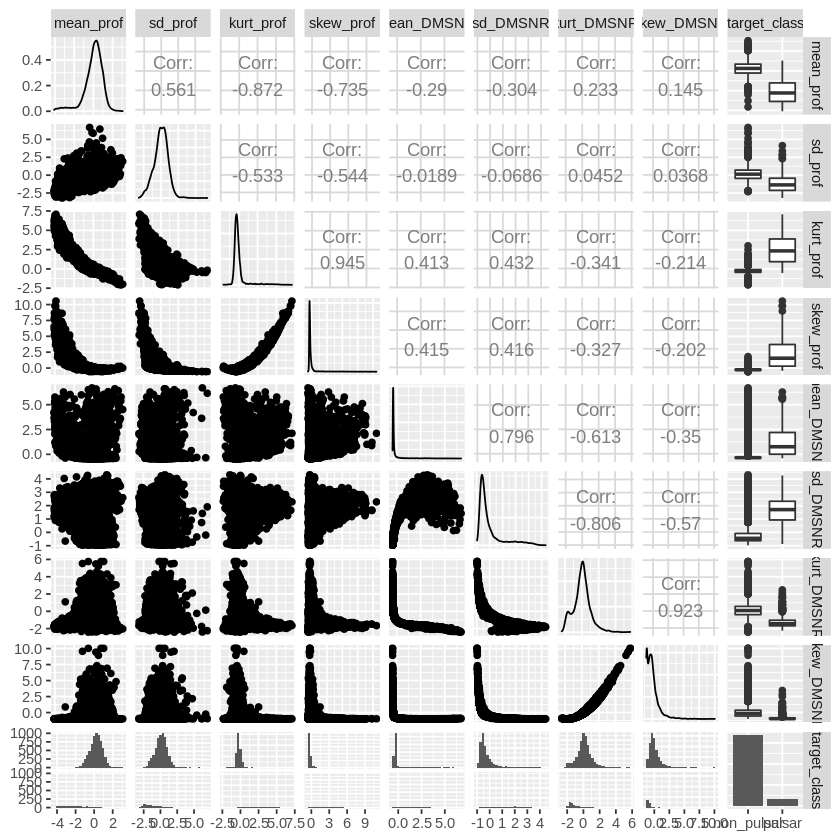

In [21]:
ggpairs(scaled_pulsar_train)

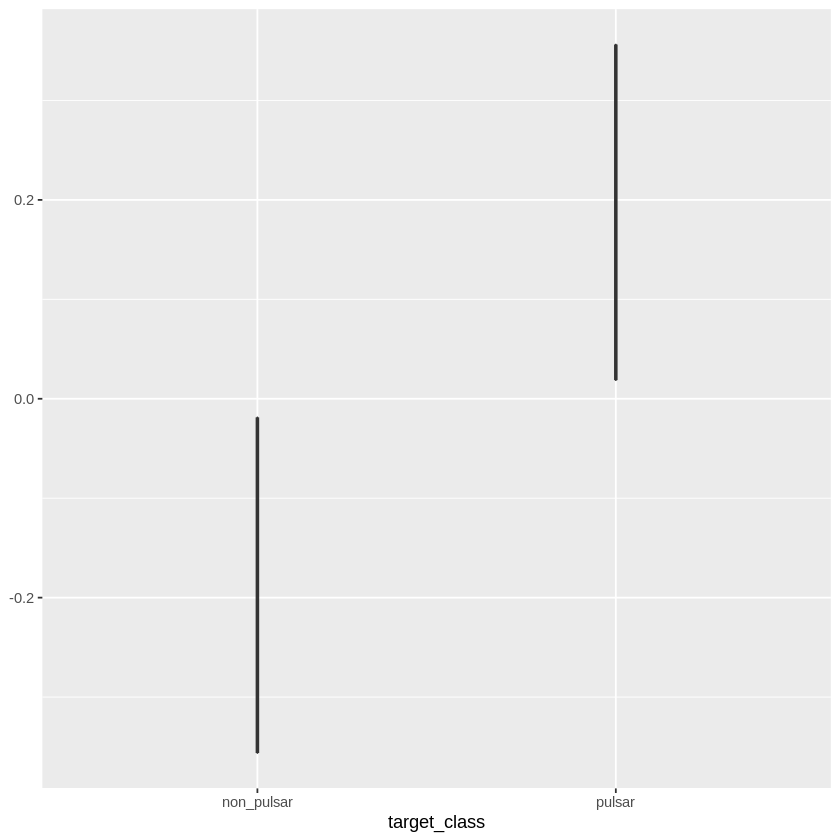

In [41]:
#Visualization
# meltData = melt(scaled_pulsar_train)
scale_train_plot = ggplot(scaled_pulsar_train, aes(x = target_class)) +
    geom_boxplot() + 
scale_train_plot
                  

## Methods

### Visualization of results

## Looking Forward